In [51]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import powerlaw


In [72]:
# Hoshen-Kopelman Clustering algorithm
#https://en.wikipedia.org/wiki/Hoshen–Kopelman_algorithm

[[ 0.  1.  1.  0.  0.  0.  0.  0.  2.  2.]
 [ 0.  1.  0.  0.  0.  0.  0.  3.  0.  2.]
 [ 0.  0.  0.  0.  4.  0.  5.  0.  2.  2.]
 [ 0.  0.  0.  0.  0.  0.  5.  0.  0.  2.]
 [ 0.  0.  7.  0.  8.  8.  0.  0.  0.  2.]
 [ 7.  0.  7.  0.  0.  0. 10. 10.  0.  0.]
 [ 7.  7.  7.  0. 10. 10. 10.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 12. 12.]
 [ 0. 13. 13.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. 13.  0.  0.  0.  0.  0. 14. 14.  0.]]
[[ 0.  0.  0.  1.  0.  0.  0.  2.  0.  0.]
 [ 0.  0.  0.  1.  1.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  1.  1.  0.  0.  0.  4.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  4.  4.  0.]
 [ 0.  6.  0.  7.  7.  7.  0.  0.  0.  0.]
 [ 0.  0.  0.  7.  0.  0.  0.  8.  8.  0.]
 [ 0.  9.  0.  0.  0. 10.  0.  8.  0.  0.]
 [ 0.  0.  0.  0. 11.  0.  8.  8.  8.  8.]
 [13.  0.  0. 11. 11.  0.  8.  0.  0.  0.]]
   Cluster_size  Cluster_count  cell_type
0           1.0            2.0        1.0
1           2.0            4.0        1.0
2           

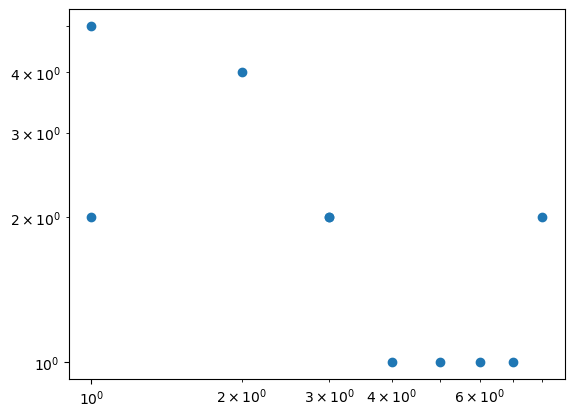

In [69]:
def clustering(m, rtype):
    """ Algorithm for finding clusters and labeling them. 
    INPUT: Matrix m with occupied 1 and unoccupied 0"""
    assert type(rtype) == int
    assert m.shape[0] == m.shape[1]
    
    dim = m.shape[0]
    largest_label = 0
    label = np.zeros([dim, dim])
    for x in range(dim):
        for y in range(dim):
            above = m[x-1, y]
            left = m[x, y-1]
            # For the boundary conditions, set above and left to zero.
            if x == 0:
                above = 0
            if y == 0:
                left = 0
            # Assign cluster IDs according to neighbours   
            if m[x,y] == rtype:
                if above != rtype and left != rtype: # no neighbors, new cluster id
                    largest_label += 1
                    label[x,y] = largest_label
                elif above == rtype and left != rtype: # cluster extends from above, change id
                    label[x,y] = label[x-1,y]
                elif above != rtype and left == rtype: # cluster extends from left, change id
                    label[x,y] = label[x,y-1]
                elif above == rtype and left == rtype: # both belong to cluster, make a union
                    m, label = cluster_union(m, label, x, y)             
    return label
            
def cluster_union(m, label, x, y):
    """
    Union the two clusters and labels both clusters the same.
    """
    if label[x-1,y] == label[x,y-1]: # If labels are the same, then set x,y as same label
        label[x,y] = label[x-1,y]
        return m, label
    else: # else different clusters so rename one
        new_id, old_id = np.min([label[x-1,y], label[x,y-1]]), np.max([label[x-1,y], label[x,y-1]])
        label[x,y] = new_id # set label of current x,y
        label[label == old_id] = new_id # change all old IDs to the new one
    return m, label

def run_clustering(m):
    """
    Runs the clustering algorithm for each of the cell types, returns a pandas dataframe with the columns cluster size, count, id.
    INPUT: the matrix with the different IDs in the cells. 
    """
    clusters = pd.DataFrame()
    # Run each of the cluster types in a loop
    for i in np.unique(m)[1:]: # not the zeros
        cluster_ids = clustering(m, int(i))
        cluster_size = np.unique(cluster_ids, return_counts=True) # count size of clusters in matrix of cell types
        size, count = np.unique(cluster_size[1][1:], return_counts=True) # select only the cells that contain something (first element is empty)
        # f
        clusters = pd.concat([clusters, pd.DataFrame([size, count, i * np.ones(len(count))]).T], axis = 0)
        print(cluster_ids)
    clusters.columns = ['Cluster_size','Cluster_count','cell_type']
    return clusters

m = np.random.randint(0,3, (10,10), dtype=int)

x = run_clustering(m)
print(x)
# Just testing the log plotting
plt.scatter(x.Cluster_size, x.Cluster_count)
plt.yscale('log'), plt.xscale('log')
plt.show()






In [67]:
from scipy.optimize import curve_fit
# Function to calculate the power-law with constants a and b
def power_law(x, a, b):
    return a*np.power(x, b)

pars, cov = curve_fit(f=power_law, ydata=np.log(xx.Cluster_size), xdata=np.log(xx.Cluster_count), p0=[0, 0], bounds=(-np.inf, np.inf))
print(pars, cov)
xx = x[x.cell_type == 1]

np.log(xx.Cluster_count)

[1.1325921 0.       ]Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
 [[4.68009461e-01 6.15745457e-09]
 [6.15745457e-09 1.35019519e-16]]


In [ ]:
# Fractal Dimension from occupancy rate and radius from centre.
from scipy.optimize import least_squares


def fractal_dimension(m, centre, radius):
    """
    Calculates the fractal dimension of the occupancy for each radius
    """
    dim = m.shape[0] # get the array dimension
    distance = np.zeros([dim,dim])
    radius = np.zeros(10,2)
    radius[:,0] = range(10) # sets the range to loop over for occupancy
    for i in range(dim):
        for j in range(dim):
            distance[i,j] = np.sqrt((centre[0] - i) ** 2 + (centre[1] - j) ** 2)
    # logic is to filter spots within distance, then multiply with m matrix to find spots where there are occupants
    # assuming empty spots are marked with zero and sum the spots within raidus and with occupants.
    for r in radius[:,0]: 
        current_distance = np.where(distance < radius, 1, 0)
        radius[r,1] = (current_distance * m).sum()
    
    fractal_d = least_squares(np.log(radius[:,1]), np.log(radius[:,0])).x[1] # area is y axis and radius on x, returns coef
    return fractal_d

In [ ]:
from scipy.optimize import curve_fit

def power_law(x, a, b):
    return a*np.power(x, b)

pars, cov = curve_fit(f=power_law, xdata=xx.Cluster_size, ydata=xx.Cluster_count, p0=[300, -1.8], bounds=(-np.inf, np.inf))

print(pars)

In [87]:
# Fractal Dimension from occupancy rate and radius from centre.
from scipy.optimize import least_squares


def fractal_dimension(m, center):
    """
    Calculates the fractal dimension of the occupancy for each radius
    """
    dim = m.shape[0] # get the array dimension
    distance = np.zeros([dim,dim])
    radius = np.zeros([10,2])
    radius[:,0] = range(10) # sets the range to loop over for occupancy
    for i in range(dim):
        for j in range(dim):
            distance[i,j] = np.sqrt((center - i) ** 2 + (center - j) ** 2)
    # logic is to filter spots within distance, then multiply with m matrix to find spots where there are occupants
    # assuming empty spots are marked with zero and sum the spots within raidus and with occupants.
    for r in radius[:,0]: 
        current_distance = np.where(distance < r, 1, 0)
        area = (current_distance * m)[0].sum()
        radius[r,1] = 1
        
    fractal_d = least_squares(np.log(radius[:,1]), np.log(radius[:,0])).x[1] # area is y axis and radius on x, returns coef
    return fractal_d

fractal_dimension(m, 5)


0


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices